In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np


import torch.nn.functional as F

In [2]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()

        # self.curr_stack = nn.Sequential(
        #     nn.Linear(28*28, 28*28 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2, 28*28 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2, 28*28 // 2 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2 // 2, 28*28 // 2 // 2 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2 // 2 // 2, 10),
        #     nn.LogSoftmax(dim=1)
        # )

       
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=6, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features= 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features= 60, out_features = 10)

    def forward(self, tensor):
        
        # hidden layer 1
        tensor = self.conv1(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride= 2)
        
        # hidden layer 2
        
        tensor = self.conv2(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride = 2)
        
        #hidden layer 3
        
        tensor = tensor.reshape(-1, 12 * 4* 4)
        tensor = self.fc1(tensor)
        tensor = F.relu(tensor)
        
        #hidden layer 4
        
        tensor = self.fc2(tensor)
        tensor = F.relu(tensor)
        
        #output layer
        
        tensor = self.out(tensor)
        
        return tensor

In [3]:
def calculate_metrics(loader: DataLoader, model: nn.Module):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


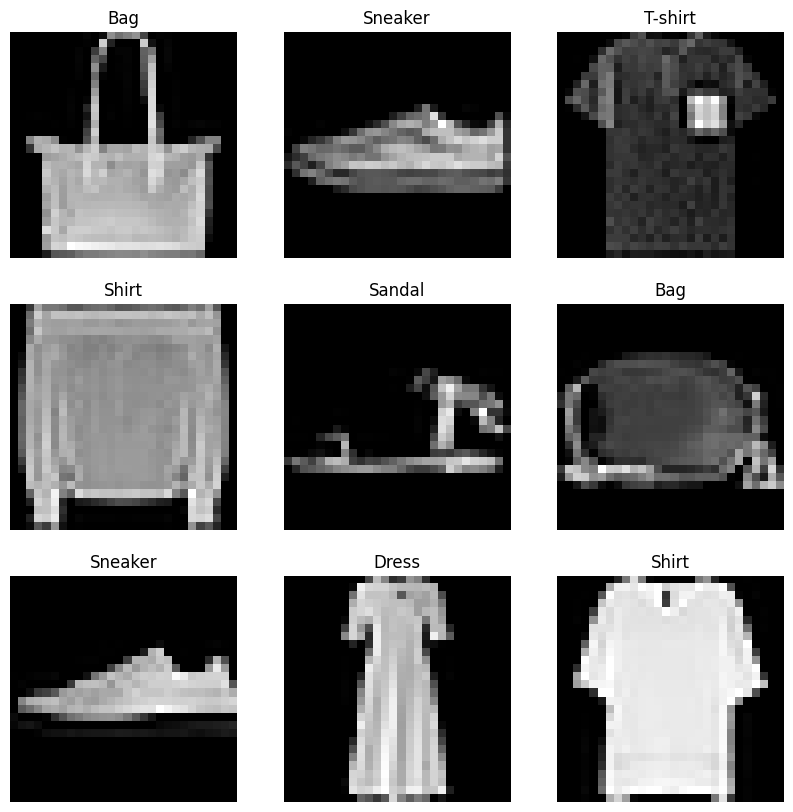

In [5]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(trainset), size = (1,)).item()
    image, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [6]:
net = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

val_acc, val_rec, val_prec, val_f1 =0,0,0,0
epoch = 0


while val_acc < 0.95 and val_rec < 0.95 and val_prec < 0.95 and val_f1 < 0.95:
    
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss:nn.CrossEntropyLoss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

    train_acc, train_rec, train_prec, train_f1 = calculate_metrics(trainloader, net)
    print(f'Training - Accuracy: {train_acc}, Recall: {train_rec}, Precision: {train_prec}, F1 Score: {train_f1}')

    val_acc, val_rec, val_prec, val_f1 = calculate_metrics(valloader, net)
    print(f'Validation - Accuracy: {val_acc}, Recall: {val_rec}, Precision: {val_prec}, F1 Score: {val_f1}')

    epoch+=1

print('Finished Training')

Epoch 1, Loss: 2.297


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.24348333333333333, Recall: 0.24348333333333336, Precision: 0.26348319564817363, F1 Score: 0.16025815065717952


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.245, Recall: 0.24500000000000002, Precision: 0.16573777921129576, F1 Score: 0.16049516762988097
Epoch 2, Loss: 2.276


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.24681666666666666, Recall: 0.24681666666666663, Precision: 0.15957675101449836, F1 Score: 0.15249118895121974


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2467, Recall: 0.24669999999999997, Precision: 0.1559624790861564, F1 Score: 0.1517834253138756
Epoch 3, Loss: 2.210


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.23428333333333334, Recall: 0.23428333333333334, Precision: 0.2572405609776438, F1 Score: 0.133733118544983


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2362, Recall: 0.23620000000000002, Precision: 0.2550880001682322, F1 Score: 0.1356012723903905
Epoch 4, Loss: 1.920


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.41738333333333333, Recall: 0.41738333333333333, Precision: 0.40451668829077614, F1 Score: 0.34765540922653504


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.4194, Recall: 0.4194, Precision: 0.41112459863841755, F1 Score: 0.35040651792233557
Epoch 5, Loss: 1.433
Training - Accuracy: 0.5881333333333333, Recall: 0.5881333333333333, Precision: 0.5836893086655446, F1 Score: 0.5470946778441665
Validation - Accuracy: 0.59, Recall: 0.59, Precision: 0.5791820387130225, F1 Score: 0.548600852737223
Epoch 6, Loss: 1.125
Training - Accuracy: 0.64165, Recall: 0.64165, Precision: 0.6355692877517127, F1 Score: 0.6130635311174943
Validation - Accuracy: 0.6421, Recall: 0.6421000000000001, Precision: 0.6346987472730777, F1 Score: 0.6129534071433504
Epoch 7, Loss: 0.953
Training - Accuracy: 0.67065, Recall: 0.67065, Precision: 0.6605741729656878, F1 Score: 0.6542199469707635
Validation - Accuracy: 0.669, Recall: 0.6689999999999999, Precision: 0.658577381145815, F1 Score: 0.6525033380220553
Epoch 8, Loss: 0.864
Training - Accuracy: 0.6931333333333334, Recall: 0.6931333333333334, Precision: 0.6918825761158909, F1 Score: 0.68488394259234

KeyboardInterrupt: 